# ROBUST

This notebook is used to reproduce produce the figures for the paper, "ROBUST: Replicating and Understanding 208 Bugs in Robot Operating System".

In [1]:
import collections
import os
import typing as t

import IPython
import robust
import tabulate
import yaml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from robust import BugDescription, ROBUST

# Apply the default theme
sns.set_theme()
    
DATASET = ROBUST("..")
DIR_FIGURES = os.path.join(os.getcwd(), '../figures')


def table(contents: t.Sequence[t.Sequence[t.Any]]) -> None:
    """Produces a pretty table in the notebook."""
    html = IPython.display.HTML(tabulate.tabulate(con|tents, tablefmt='html'))
    IPython.display.display|(html)
    
    
def counter_to_df(counter: collections.Counter, index: str) -> pd.DataFrame:
    """Converts a counter to a Pandas DataFrame."""
    # https://stackoverflow.com/questions/31111032/transform-a-counter-object-into-a-pandas-dataframe
    df = pd.DataFrame.from_dict(counter, orient='index')
    df = df.reset_index()
    df = df.rename(columns={'index': index, 0: 'Frequency'})
    return df.set_index(index)


def normalize_language(language: str) -> str:
    """Renames a given language in the dataset for the sake of reporting."""
    renamings = {
        'srv': 'ROS IDL',
        'ROS Message': 'ROS IDL',
        '.gitattributes': 'Other',
        'Other YAML': 'Other',
        'RViz': 'Other',
        'udev rules': 'Other',
        'Shell': 'Other',
        'Xacro': 'Xacro/URDF',
        'URDF': 'Xacro/URDF', 
    }
    return renamings.get(language, language)

### What languages are involved in the fix?

Num. Fixed: 219
             Frequency
Language              
C++                112
Python              27
CMake               27
Xacro/URDF          20
Package XML         30
Param YAML           5
Launch XML          12
COLLADA              1
Other                5
ROS IDL              2
Other XML            1
URScript             3
C                    3
STL                  2


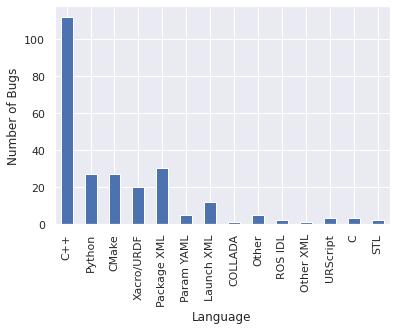

In [2]:
def language_vs_number_of_bugs() -> None:
    num_fixed = 0
    tally = collections.Counter()
    for bug_description in DATASET.values():
        languages = bug_description.fix.languages or []
        if not languages:
            continue
            
        for language in (bug_description.fix.languages or []):
            language = normalize_language(language)
            tally[language] += 1
        num_fixed += 1
            
    df = counter_to_df(tally, 'Language')
    print(f"Num. Fixed: {num_fixed}")
    print(df)
    
    ax = df.plot(kind='bar', ylabel='Number of Bugs', legend=False)
    fig = ax.get_figure()
    fig.savefig(os.path.join(DIR_FIGURES, "language-vs-number-of-bugs.pdf"))
    

language_vs_number_of_bugs()

We observe that, although half of bug fixes are written in C++. The other half are scattered across a bunch of different languages. Many of those languages don't have associated analysis tools.

* There are lots of build-related issues (CMake, Package XML).

* see: https://ieeexplore.ieee.org/document/8206237
* see: https://repositorium.sdum.uminho.pt/bitstream/1822/52261/1/P-00N-9XE.pdf
* mention: https://www.semanticscholar.org/paper/The-Robot-Operating-System%3A-Package-reuse-and-Estefo-Simmonds/4609b803f29773b3a32f2b3dc1d75bcacf73ecac


Threat to validity:
* the packages we picked are representative, but our results are naturally limited to those packages. Our relative frequencies may not be representative of all bugs in ROS as a whole. The ROBUST benchmark provides you with actual bugs that other researchers can study! That's the key point of this study.

### How many fixes cover more than one language?

BugDescription(filename='/home/wasowski/work/robust/motoman/65e7ee6/65e7ee6.bug')
                     Frequency
Number of Languages           
1                          200
2                           14
3                            3
4                            1
5                            1


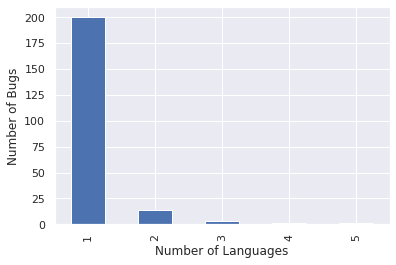

In [3]:
def number_of_languages_in_fix() -> None:
    tally = collections.Counter()
    for bug_description in DATASET.values():
        languages = set()
        for language in (bug_description.fix.languages or []):
            languages.add(normalize_language(language))
        num_languages = len(languages)
        
        # ignore bugs without a fix
        if num_languages > 0:
            tally[num_languages] += 1
            
        if num_languages == 5:
            print(bug_description)
            
    # put the x-axis labels in the correct order
    ordered_tally = collections.Counter()
    for num_languages in sorted(tally):
        ordered_tally[num_languages] = tally[num_languages]

    df = counter_to_df(ordered_tally, 'Number of Languages')
    print(df)
    
    ax = df.plot(kind='bar', ylabel='Number of Bugs', legend=False)
    fig = ax.get_figure()
    fig.savefig(os.path.join(DIR_FIGURES, "number-of-languages-in-fix.pdf"))
    

number_of_languages_in_fix()

* there are plenty of multi-language bugs in ROS due to its distributed nature.
* but most of the faults are local to a single language. this makes fixing them easier!

TODO:
* either explain how we count the number of languages (i.e., do we consider file renamings without content changes?)
* the bug fix involving five languages doesn't really involve any content changes

### How many files are modified by the fix?

Total bugs fixed: 219
Bugs fixed in one file:  64.38%
Bugs fixed in two files:  18.72%


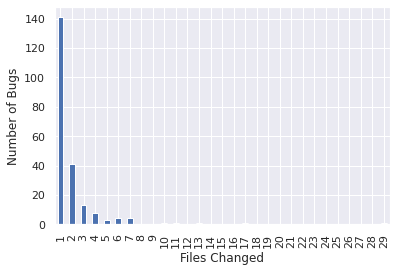

In [4]:
def num_files_fixed() -> None:
    tally = collections.Counter()
    for description in DATASET.values():
        fixed_files = description.fix.fix_in
        if fixed_files is None:
            num_fixed = 0
        else:
            num_fixed = len(fixed_files)
        tally[num_fixed] += 1
        
    max_files_changed = max(tally)
    files_changed_to_num_bugs = {n: tally[n] for n in range(1, max_files_changed + 1)}
    total_bugs_fixed = sum(files_changed_to_num_bugs.values())
        
    df = counter_to_df(files_changed_to_num_bugs, 'Files Changed')
    print(f"Total bugs fixed: {total_bugs_fixed}")
    print(f"Bugs fixed in one file: {files_changed_to_num_bugs[1] / total_bugs_fixed : .2%}")
    print(f"Bugs fixed in two files: {files_changed_to_num_bugs[2] / total_bugs_fixed : .2%}")
    
    ax = df.plot(kind='bar', ylabel='Number of Bugs', legend=False)
    fig = ax.get_figure()
    fig.savefig(os.path.join(DIR_FIGURES, "number-of-files-fixed.pdf"))


num_files_fixed()

NOTE:

* we should note our methodology for counting which files were fixed (i.e., we manually identified which files were associated with the bug fix rather than relying on the files that were changed by the commit; this allows us to ignore unrelated changes).

### What is the size of the change difference?

TODO: the text should explain that this statistic is an overapproximation. It will include changes (e.g., formatting, refactoring, other things) that are unrelated to the actual bug fix.


SEE:
* https://github.com/WillKoehrsen/Data-Analysis/blob/master/univariate_dist/Histogram%20and%20Density%20Plot.ipynb
* https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0

skipping bug [missing stats]: BugDescription(filename='/home/wasowski/work/robust/mavros/b96bf67/b96bf67.bug')
skipping bug [missing stats]: BugDescription(filename='/home/wasowski/work/robust/geometry2/561d66b/561d66b.bug')
skipping bug [missing stats]: BugDescription(filename='/home/wasowski/work/robust/motoman/ddc6f36/ddc6f36.bug')
skipping bug [missing stats]: BugDescription(filename='/home/wasowski/work/robust/kobuki/af7946f/af7946f.bug')
skipping bug [missing stats]: BugDescription(filename='/home/wasowski/work/robust/universal_robot/21b86f6/21b86f6.bug')
skipping bug [missing stats]: BugDescription(filename='/home/wasowski/work/robust/care-o-bot/79867c8/79867c8.bug')
skipping bug [missing stats]: BugDescription(filename='/home/wasowski/work/robust/kobuki/55e84a6/55e84a6.bug')
skipping bug [missing stats]: BugDescription(filename='/home/wasowski/work/robust/kobuki/f548cc7/f548cc7.bug')
skipping bug [missing stats]: BugDescription(filename='/home/wasowski/work/robust/kobuki/d9aa65

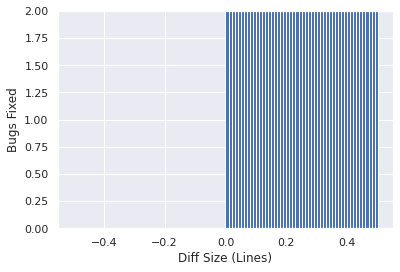

In [5]:
import dataclasses

@dataclasses.dataclass
class FixChanges:
    bug: str
    total: int = 0
    insertions: int = 0
    deletions: int = 0

    @staticmethod
    def for_bug(description: BugDescription) -> 'FixChanges':
        changes = FixChanges(bug=description.id)
        for commit in description.fix.commits:
            if commit.stats is None:
                raise ValueError('missing stats')
            changes.total += commit.stats.total.lines
            changes.insertions += commit.stats.total.insertions
            changes.deletions += commit.stats.total.deletions
        return changes


def num_lines_changed_by_bug(description: BugDescription) -> int:
    lines_changed = 0
    for commit in description.fix.commits:
        if commit.stats is None:
            raise ValueError('missing stats')
        lines_changed += commit.stats.total.lines
    return lines_changed


def generate_fix_changes_dataframe() -> None:
    changes = []
    for description in DATASET.values():
        try:
            changes.append(FixChanges.for_bug(description))
        except ValueError as error:
            print(f"skipping bug [{error}]: {description}")
            continue
    return pd.DataFrame(changes)
    

def num_lines_changed() -> None:
    tally = collections.Counter()
    
    for description in DATASET.values():
        try:
            lines_changed = num_lines_changed_by_bug(description)
        except ValueError as error:
            print(f"skipping bug [{error}]: {description}")
            continue
        tally[lines_changed] += 1
        
    # put x-axis labels into correct order
    ordered_tally = collections.Counter()
    for lines_changed in sorted(tally):
        ordered_tally[lines_changed] = tally[lines_changed]
        
    five_lines_or_fewer = sum(tally[c] for c in range(1, 6))
    six_to_ten_lines = sum(tally[c] for c in range(6, 11))
    eleven_to_fifteen_lines = sum(tally[c] for c in range(11, 16))
    more_than_sixteen_lines = sum(tally[c] for c in range(16, max(tally) + 1))
    more_than_200_lines = sum(tally[c] for c in range(201, max(tally) + 1))
    
    print(f"bug fixes without any lines changed (i.e., only file renamings): {tally[0]}")
    print(f"0-5 lines: {five_lines_or_fewer}")
    print(f"6-10 lines: {six_to_ten_lines}")
    print(f"11-15 lines: {eleven_to_fifteen_lines}")
    print(f"More than 16 lines: {more_than_sixteen_lines}")
    print(f"More than 200 lines: {more_than_200_lines}")
            
    # build a series
    vals = []
    for lines_changed in tally:
        vals += tally[lines_changed] * [lines_changed]
    total_bugs_fixed = len(vals)
    print(f"total bugs fixed: {total_bugs_fixed}")
        
    s = pd.Series(v for v in vals if v <= 200)
    ax = s.plot.hist(bins=100, cumulative=True)
    ax.set_ylabel('Bugs Fixed')
    ax.set_ylim(0, total_bugs_fixed)
    ax.set_xlabel('Diff Size (Lines)')
    fig = ax.get_figure()
    fig.savefig(os.path.join(DIR_FIGURES, "lines-changed-leq-200.pdf"))
        
        
num_lines_changed()

### How often is a test case provided as part of the fix commit(s)?

* TODO: we could grep for test code? (e.g., look at CMake changes, Google Test, Python tests)
* TODO: link the results of this question to Adam Alami's work on behavior in ROS development (emphasis on developing new features rather than maintenance)

In [6]:
def does_commit_include_test(commit: robust.robust.FixCommit) -> bool:
    if commit.stats is None:
        raise ValueError('missing stats')
    modified_files = set(s.filename for s in commit.stats.files)
    
    # check if file is a test file based on its name
    # this is incredibly basic, but it looks like very few commits provided tests
    for filename in modified_files:
        if 'test' in filename:
            print(filename)
    return any(True for filename in modified_files if 'test' in filename)
    

def does_fix_include_test(description: BugDescription) -> bool:
    for commit in description.fix.commits:
        if does_commit_include_test(commit):
            return True
    return False
    
    
def how_often_is_test_provided_with_fix() -> None:
    is_provided = 0
    is_not_provided = 0
    skipped = 0
    
    for description in DATASET.values():
        try:
            if does_fix_include_test(description):
                is_provided += 1
            else:
                is_not_provided += 1
        except ValueError:
            skipped += 1

    print(f"Bug fixes that provide a test case: {is_provided}")
    print(f"Bug fixes that do not provide a test case: {is_not_provided}")
    print(f"Unable to determine whether bug fix provides test case: {skipped}")
    
    
how_often_is_test_provided_with_fix()

Bug fixes that provide a test case: 0
Bug fixes that do not provide a test case: 2
Unable to determine whether bug fix provides test case: 219


In [7]:
def plot_phase() -> None:
    for description in DATASET.values():
        print(description)

### How many bugs do not have CWE?

In [ ]:
def bugs_without_CWE() -> None:
    count = 0
    for description in DATASET.values():
        if description.classification is None:
            print (f"SKIPPED: {description}")
        else:
            if not description.classification.startswith("CWE"):
                if not "no CWE" in description.classification: 
                    print (description.id + " " + description.classification)
                count += 1
    return count
   
print (f"\nThe total number of bugs without CWE: {bugs_without_CWE()}")